# MNIST: Digit Recognizer Getting Started Challenge

*Author: Benjamin Sautermeister*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np

### Load Data

In [2]:
train = pd.read_csv('inputs/train.csv')
train.shape

(42000, 785)

In [3]:
test = pd.read_csv('inputs/test.csv')
test.shape

(28000, 784)

#### Convert image data to numpy array of type *float* and split the label out of the training data

In [4]:
x_train = (train.iloc[:, 1:].values).astype(np.float32)
y_train = (train.iloc[:, 0].values).astype(np.int32)
x_test = test.values.astype(np.float32)

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

### Data Visualization

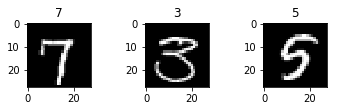

In [6]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

### Data Preprocessing

In [7]:
mean_x = x_train.mean().astype(np.float32)
std_x = x_train.std().astype(np.float32)

def standardize(x):
    return (x - mean_x) / std_x

In [8]:
y_train = tf.keras.utils.to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

### Data splits

In [22]:
seed = 42
np.random.seed(seed)

In [23]:
inputs = x_train
label = y_train
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=seed)

### Model

In [24]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(standardize, input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(32,(5,5), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Conv2D(32,(3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Conv2D(32,(5,5), padding='same', strides=(2,2), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Conv2D(32,(5,5), padding='same', strides=(2,2), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.1)

In [26]:
BATCH_SIZE = 100
batches = gen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_batches = gen.flow(x_val, y_val, batch_size=BATCH_SIZE)

In [27]:
model = create_model()

In [ ]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None
)

checkpoint_model_selection_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model_selection/ckp',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=1)

history = model.fit_generator(
    generator=batches,
    steps_per_epoch=int(batches.n / BATCH_SIZE),
    epochs=100,
    verbose=1,
    validation_data=val_batches,
    validation_steps=int(val_batches.n / BATCH_SIZE),
    callbacks=[
        checkpoint_model_selection_callback,
        reduce_lr_callback,
        early_stopping_callback
    ])

Epoch 1/100
337/340 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9975
Epoch 00001: val_acc improved from -inf to 0.99405, saving model to checkpoints/model_selection/ckp

Consider using a TensorFlow optimizer from `tf.train`.
340/340 [==============================] - 7s 21ms/step - loss: 0.0496 - acc: 0.9975 - val_loss: 0.0683 - val_acc: 0.9941
Epoch 2/100
339/340 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9975
Epoch 00002: val_acc improved from 0.99405 to 0.99459, saving model to checkpoints/model_selection/ckp

Consider using a TensorFlow optimizer from `tf.train`.
340/340 [==============================] - 7s 21ms/step - loss: 0.0481 - acc: 0.9975 - val_loss: 0.0664 - val_acc: 0.9946
Epoch 3/100
337/340 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9977
Epoch 00003: val_acc did not improve from 0.99459
340/340 [==============================] - 7s 21ms/step - loss: 0.0470 - acc: 0.9977 - val_loss: 0.0661 - val_acc: 

In [18]:
def plot_values(train_values, valid_values, y_label):
    epochs = range(1, len(train_values) + 1)
    plt.clf()
    plt.plot(epochs, train_values, 'b')
    if valid_values is not None:
        plt.plot(epochs, valid_values, 'g')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.show()
    
history_dict = history.history

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plot_values(loss_values, val_loss_values, 'Loss')

In [ ]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plot_values(acc_values, val_acc_values, 'Accuracy')

### Submission

#### Option A: Retrain on full training set

In [14]:
model = create_model()

In [15]:
checkpoint_train_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/train/ckp',
    monitor='acc',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=1)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='acc', 
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='acc',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None
)

batches = gen.flow(inputs, label, batch_size=BATCH_SIZE)
history = model.fit_generator(
    generator=batches,
    steps_per_epoch=int(batches.n / BATCH_SIZE),
    epochs=200,
    verbose=2,
    callbacks=[
        checkpoint_train_callback,
        reduce_lr_callback,
        early_stopping_callback
    ])

Epoch 1/200

Epoch 00001: acc improved from -inf to 0.87550, saving model to checkpoints/train/ckp

Consider using a TensorFlow optimizer from `tf.train`.
 - 11s - loss: 1.0677 - acc: 0.8755
Epoch 2/200

Epoch 00002: acc improved from 0.87550 to 0.96279, saving model to checkpoints/train/ckp

Consider using a TensorFlow optimizer from `tf.train`.
 - 8s - loss: 0.6454 - acc: 0.9628
Epoch 3/200

Epoch 00003: acc improved from 0.96279 to 0.97488, saving model to checkpoints/train/ckp

Consider using a TensorFlow optimizer from `tf.train`.
 - 8s - loss: 0.4681 - acc: 0.9749
Epoch 4/200

Epoch 00004: acc improved from 0.97488 to 0.97600, saving model to checkpoints/train/ckp

Consider using a TensorFlow optimizer from `tf.train`.
 - 8s - loss: 0.3567 - acc: 0.9760
Epoch 5/200

Epoch 00005: acc improved from 0.97600 to 0.97902, saving model to checkpoints/train/ckp

Consider using a TensorFlow optimizer from `tf.train`.
 - 9s - loss: 0.2797 - acc: 0.9790
Epoch 6/200

Epoch 00006: acc improve

#### Option B: Load best checkpoint:

In [ ]:
model = create_model()

In [16]:
latest = tf.train.latest_checkpoint('checkpoints/train')
model.load_weights(latest)

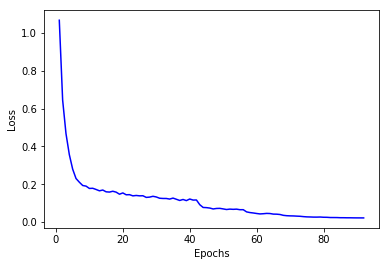

In [19]:
history_dict = history.history
loss_values = history_dict['loss']
plot_values(loss_values, None, 'Loss')

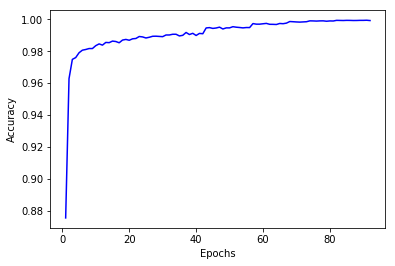

In [20]:
acc_values = history_dict['acc']
plot_values(acc_values, None, 'Accuracy')

In [21]:
predictions = model.predict_classes(x_test, verbose=0)

submissions=pd.DataFrame({
    "ImageId": list(range(1,len(predictions)+1)),
    "Label": predictions
})
submissions.to_csv("submission.csv", index=False, header=True)